## Physionet filtered data exploration

In [125]:
import os
import sys
os.chdir("/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/bin")
sys.path.append(os.getcwd()) 
import torch

from flower.task import Net, train
import glob
import torch
# import dataloader
from torch.utils.data import DataLoader
from lib.dataset_utils import *
%matplotlib inline
%load_ext autoreload
%autoreload 2
from lib.physionet import PhysioNet, variable_time_collate_fn, get_data_min_max
from sklearn import model_selection
from torch.utils.data import DataLoader
from lib import utils
from lib.dataset_utils import store_dataset_physionet
import matplotlib.pyplot as plt
from lib.plot import plot_trajectories

path_prefix = "/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/data"
prefix = "physionet"
batch_size = 64
classif = False
noise_weight = 0.1
max_t_extrap = 5
n_total_tp = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
amp_start = 1.0
amp_end = 1.0 
freq_start =1.0
freq_end = freq_start
epochs = 5
batch_size = 3
sample_tp = 0.9
n_samples = 4
max_t_extrap = 50
lr_val = 0.01
cut_tp = None
extrap = None
rec_layers = 3
gen_layers = 3
units = 500
gru_units = 500
latents = 30
rec_dims = 40

from types import SimpleNamespace
args = SimpleNamespace()
args.sample_tp = 0
args.cut_tp = None
args.extrap = None


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [126]:
####################################
#     Federated training results
####################################

result_json = glob.glob(f"../results_physionet_filtered/**/federated_training/**/**/**/results.json", recursive=True)
result_json = list(set(result_json))
result_json

df_centralized_evaluate = pd.DataFrame()
df_federated_evaluate = pd.DataFrame()
df_aggregation = pd.DataFrame()
for file in result_json:
    df_centralized_evaluate_temp, df_federated_evaluate_temp, df_aggregation_temp = read_loss_file(file)
    df_centralized_evaluate = pd.concat([df_centralized_evaluate, df_centralized_evaluate_temp])
    df_federated_evaluate = pd.concat([df_federated_evaluate, df_federated_evaluate_temp])
    df_aggregation = pd.concat([df_aggregation, df_aggregation_temp])
df = pd.concat([df_centralized_evaluate, df_federated_evaluate])
df_summary_lambdas = get_summary_lambdas(df_aggregation)

df_federated = df

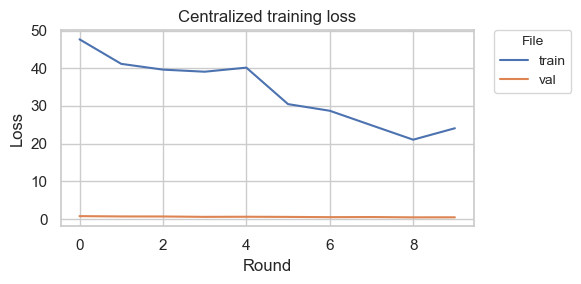

                                              run_id  train_loss  val_loss
0  10_epochs_lr_0.001-batchsize_64_clipping_False...   21.054672  0.467368


In [127]:
####################################
#     Centralized training results
####################################

result_json_centralized = glob.glob(f"../results_physionet_filtered/**/centralized_training/**/**/**/loss_per_epoch.csv", recursive=True)
result_json_centralized = list(set(result_json_centralized))
result_json_centralized

df_centralized = pd.DataFrame()
for file in result_json_centralized:
    df_centralized_temp = pd.read_csv(file)
    df_centralized_temp['run_id'] = file.split("/")[-3] + "_" + file.split("/")[-2]
    df_centralized = pd.concat([df_centralized, df_centralized_temp])
df_centralized = df_centralized.reset_index(drop=True)
df_centralized

# get the min train and val loss for each run_id
df_centralized_min = df_centralized.groupby('run_id').agg({'train_loss': 'min', 'val_loss': 'min'}).reset_index()

# create a column called loss and another called type that takes eithe train or val based on whether the value comes from train_loss or val_loss
df_centralized['loss'] = df_centralized['train_loss']
df_centralized['type'] = 'train'
df_centralized_val = df_centralized.copy()
df_centralized_val['loss'] = df_centralized['val_loss']
df_centralized_val['type'] = 'val'
df_centralized = pd.concat([df_centralized, df_centralized_val])
df_centralized = df_centralized.reset_index(drop=True)
df_centralized["client"] = "centralized_training"

# plot centralized training loss
plt.figure(figsize=(6, 3))
sns.lineplot(data=df_centralized, x='epoch', y='loss',
              hue='type',  markers=True, dashes=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
            borderaxespad=0., title='File', fontsize='small', title_fontsize='small')
plt.xlabel("Round")
plt.ylabel("Loss")
plt.title("Centralized training loss")
plt.tight_layout()
plt.show()

print(df_centralized_min)

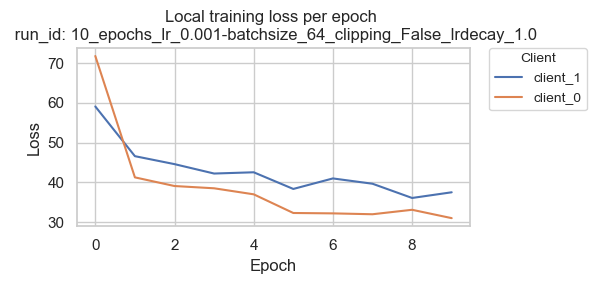

     client                                             run_id  \
0  client_0  10_epochs_lr_0.001-batchsize_64_clipping_False...   
1  client_1  10_epochs_lr_0.001-batchsize_64_clipping_False...   

   train_loss_min  val_loss_min  
0       31.038357      0.669298  
1       36.109692      0.684140  


In [128]:
####################################
#     Local training results
####################################

result_json_local = glob.glob(f"../results_physionet_filtered/**/local_training/**/loss_per_epoch.csv", recursive=True)
result_json_local = list(set(result_json_local))
result_json_local

# plot loss per epoch
df_local = pd.DataFrame()
for file in result_json_local:
    df_local_temp = pd.read_csv(file)
    df_local_temp["client"] = file.split("/")[-5]
    df_local_temp["run_id"] = file.split("/")[-3] + "_" + file.split("/")[-2]
    df_local = pd.concat([df_local, df_local_temp])


# identify minimum loss per client and run_id
df_local_min = df_local.groupby(["client", "run_id"]).min().reset_index()
df_local_min = df_local_min[["client", "run_id", "train_loss", "val_loss"]]
df_local_min = df_local_min.rename(columns={"train_loss": "train_loss_min", "val_loss": "val_loss_min"})
df_local_min

# plot the 2 clients
# set figure size
run_id = df_local_temp["run_id"].unique()[0]
df_local = df_local[df_local["run_id"] == run_id]
plt.figure(figsize=(6, 3))
sns.lineplot(data=df_local, x='epoch', y='train_loss', hue='client', markers=True, dashes=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
           borderaxespad=0., title='Client', fontsize='small', title_fontsize='small')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Local training loss per epoch \n run_id: " + run_id)
plt.tight_layout()
plt.show()

print(df_local_min)

<Figure size 1000x300 with 0 Axes>

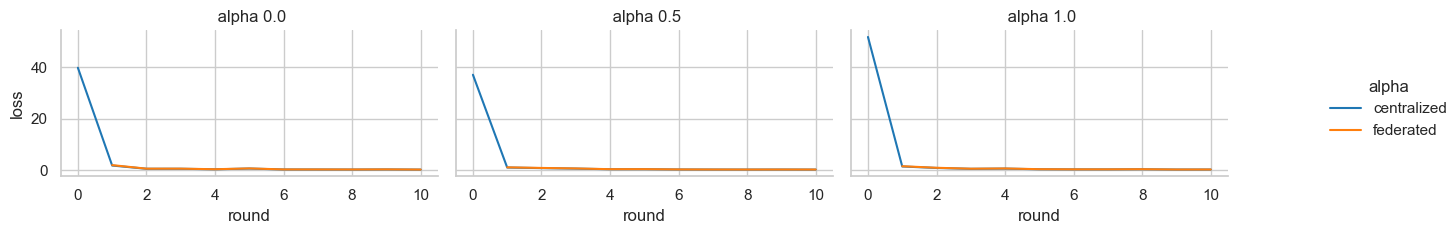

In [129]:
loss_df = df[df['type'].isin(["centralized", "federated"])]


# fig size
plt.figure(figsize=(10, 3))
# Create FacetGrid
g = sns.FacetGrid(
    loss_df,
    col="alpha",
    height=2.5,
    aspect=1.5,  # Width = height * aspect
    sharey=True
)

# Map the lineplot onto the grid
g.map_dataframe(
    sns.lineplot,
    x='round',
    y='loss',
    hue='type',
    palette='tab10'
)

# Adjustments
g.set_axis_labels("round", "loss")
g.set_titles(" alpha {col_name}")
#g.set(ylim=(0, None))

# Move legend outside
g.add_legend(title ="alpha")
g._legend.set_bbox_to_anchor((1.05, 0.5))
# legend 
g._legend.set_loc("center left")
# title
# y axis log


plt.tight_layout()
plt.show()

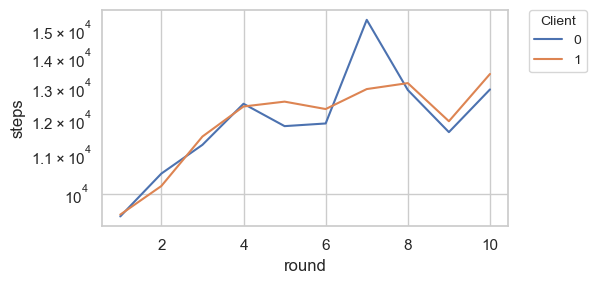

In [130]:
######################################
#  Plot the last loss vs difference
#######################################
plt.figure(figsize=(6, 3))
df_summary_lambdas_plot = df_summary_lambdas[df_summary_lambdas["alpha"]== 1.0]
sns.lineplot(data=df_summary_lambdas_plot, x='round', y='steps',
             hue='client',  markers=True, dashes=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
           borderaxespad=0., title='Client', fontsize='small', title_fontsize='small')

plt.tight_layout()
# make y axis log scale
plt.yscale('log')
plt.show()

In [131]:
#df_centralized_min and df_local_min group by id 
df_centralized_min["type"] = "centralized"
df_local_min["type"] = "local"
df_centralized_min = df_centralized_min.rename(columns={"train_loss": "train_loss_min", "val_loss": "val_loss_min"})

df_local_min_avg = df_local_min.groupby("run_id").agg({"train_loss_min": "mean", "val_loss_min": "mean"}).reset_index()
df_local_min_avg["type"] = "local"

# concatenate the two dataframes
df_min = pd.concat([df_centralized_min, df_local_min_avg])
df_min

,run_id,train_loss_min,val_loss_min,type
0,10_epochs_lr_0.001-batchsize_64_clipping_False...,21.054672,0.467368,centralized
0,10_epochs_lr_0.001-batchsize_64_clipping_False...,33.574024,0.676719,local


In [132]:
df_local_min

,client,run_id,train_loss_min,val_loss_min,type
0,client_0,10_epochs_lr_0.001-batchsize_64_clipping_False...,31.038357,0.669298,local
1,client_1,10_epochs_lr_0.001-batchsize_64_clipping_False...,36.109692,0.684140,local


In [133]:
df_federated_min = df_federated[df_federated["type"] == "federated"].groupby("hyperparameters").agg({"loss": "min"}).reset_index()
df_federated_min

,hyperparameters,loss
0,"lr: 0.001, batch_size: 64, clipping: False, lr...",0.272623


In [134]:
df_federated

,round,loss,centralized_accuracy,lr,batch_size,clipping,lrdecay,localepochs,decay_onset,dataset_name,alpha,aggregation,hyperparameters,type,federated_evaluate_accuracy
0,0,51.883338,0.010721,0.001,64,False,1.0,10,15,physionet_filtered,1.0,FedODE,"lr: 0.001, batch_size: 64, clipping: False, lr...",centralized,NaN
1,1,1.472503,0.000313,0.001,64,False,1.0,10,15,physionet_filtered,1.0,FedODE,"lr: 0.001, batch_size: 64, clipping: False, lr...",centralized,NaN
2,2,0.898048,0.000188,0.001,64,False,1.0,10,15,physionet_filtered,1.0,FedODE,"lr: 0.001, batch_size: 64, clipping: False, lr...",centralized,NaN
3,3,0.563014,0.000117,0.001,64,False,1.0,10,15,physionet_filtered,1.0,FedODE,"lr: 0.001, batch_size: 64, clipping: False, lr...",centralized,NaN
4,4,0.640964,0.000133,0.001,64,False,1.0,10,15,physionet_filtered,1.0,FedODE,"lr: 0.001, batch_size: 64, clipping: False, lr...",centralized,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,6,0.326225,NaN,0.001,64,False,1.0,10,15,physionet_filtered,0.0,FedODE,"lr: 0.001, batch_size: 64, clipping: False, lr...",federated,0.000067
6,7,0.319951,NaN,0.001,64,False,1.0,10,15,physionet_filtered,0.0,FedODE,"lr: 0.001, batch_size: 64, clipping: False, lr...",federated,0.000066
7,8,0.302230,NaN,0.001,64,False,1.0,10,15,physionet_filtered,0.0,FedODE,"lr: 0.001, batch_size: 64, clipping: False, lr...",federated,0.000062
8,9,0.342924,NaN,0.001,64,False,1.0,10,15,physionet_filtered,0.0,FedODE,"lr: 0.001, batch_size: 64, clipping: False, lr...",federated,0.000070


In [135]:
# Load dataset
c0 = torch.load(f"/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/data/physionet_filtered/client_1_test.pt", weights_only=False)
c1 = torch.load(f"/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/data/physionet_filtered/client_1_test.pt", weights_only=False)
attr_names = torch.load(f"/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/data/physionet_filtered/attr_names.pt", weights_only=False)
attr_names_filtered = attr_names

# load model weights 
model = Net()
w_cen = torch.load(f"/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/results_physionet_filtered/physionet_filtered/centralized_training/10_epochs/lr_0.001-batchsize_64_clipping_False_lrdecay_1.0/model.pth",  map_location=torch.device('cpu'), weights_only=True)
w_local = torch.load("/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/results_physionet_filtered/physionet_filtered/local_training/client_0/10_epochs/10_epochs/lr_0.001-batchsize_64_clipping_False_lrdecay_1.0/model.pth",  map_location=torch.device('cpu'), weights_only=True)
model.load_state_dict(w_cen)
#model.load_state_dict(w_local)

<All keys matched successfully>

Getting data min and max devices:  cpu


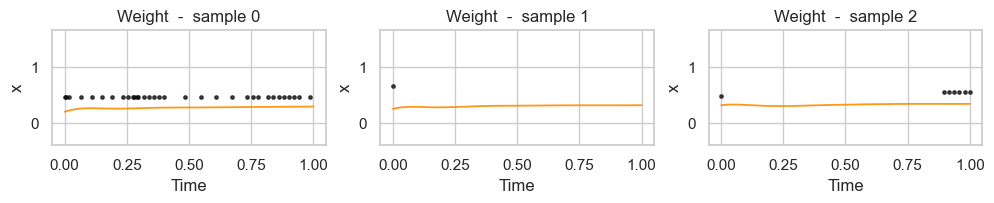

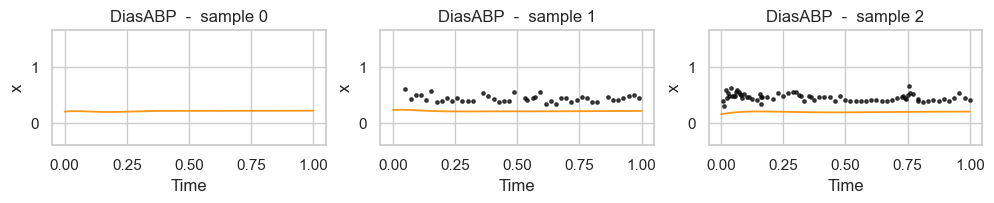

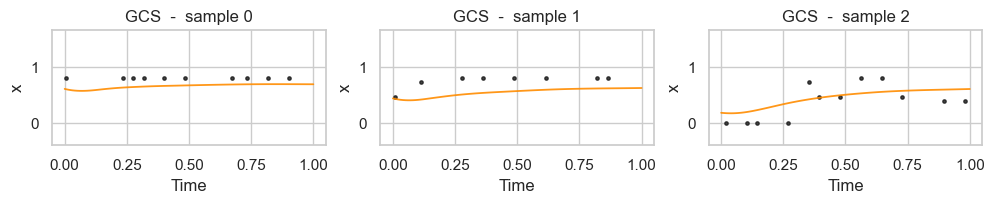

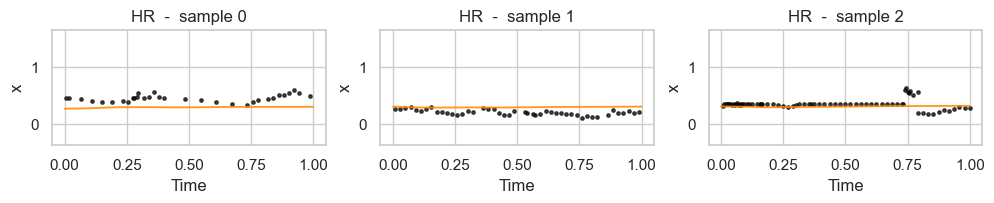

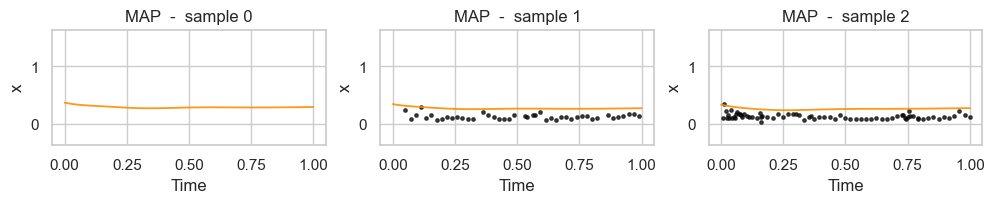

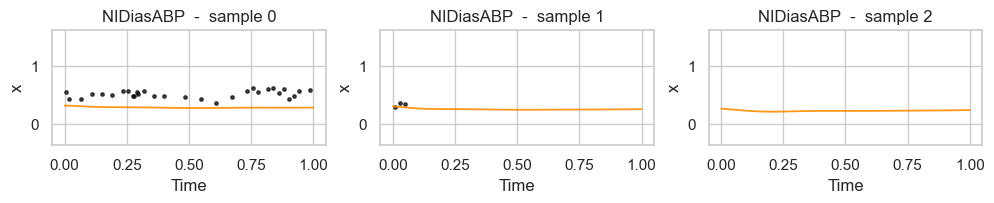

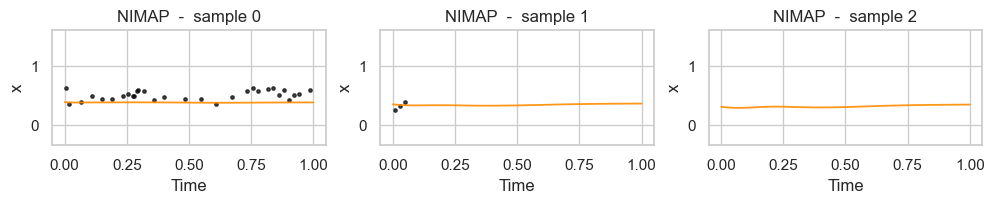

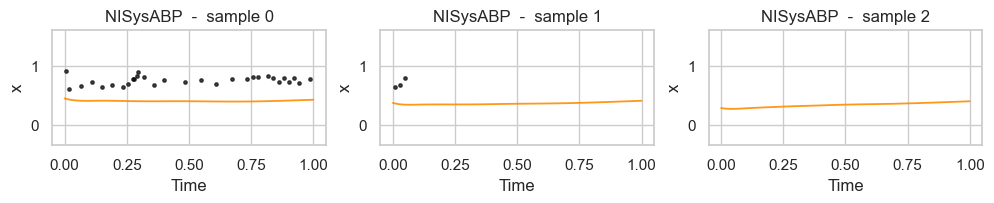

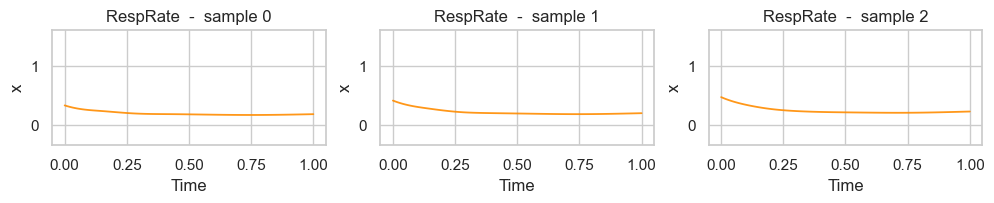

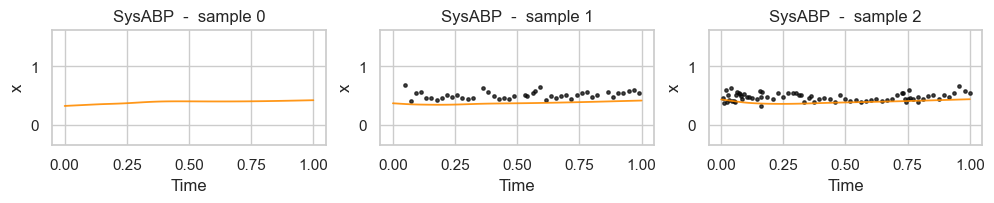

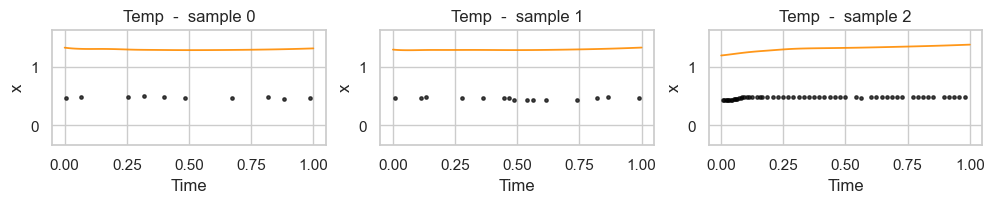

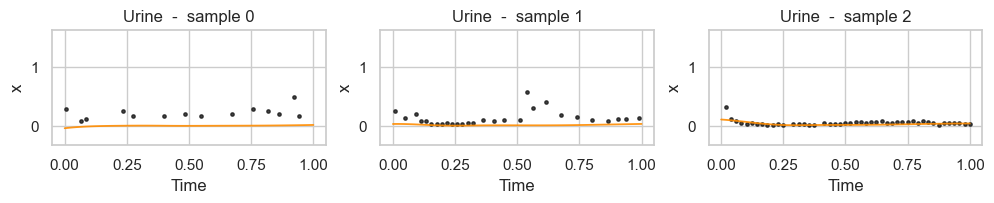

In [136]:
n_traj_to_show = 3
filtered_dataset = c0[10:40]
data_min, data_max = get_data_min_max(filtered_dataset)
testloader = DataLoader(filtered_dataset, batch_size= batch_size, shuffle=False,
    collate_fn= lambda batch: variable_time_collate_fn(batch, args, "cpu", data_type = "test",
        data_min = data_min, data_max = data_max))

testloader = utils.inf_generator(testloader)
test_dict = utils.get_next_batch(testloader)

# prepare dictionary in the format needed for prediction and plotting
data =  test_dict["data_to_predict"]
time_steps = test_dict["tp_to_predict"]
mask = test_dict["mask_predicted_data"]

observed_data =  test_dict["observed_data"]
observed_time_steps = test_dict["observed_tp"]
observed_mask = test_dict["observed_mask"]


time_steps_to_predict = time_steps
time_steps_to_predict = utils.linspace_vector(time_steps[0], time_steps[-1], 100).to(device)

with torch.no_grad():

    # Here use the model to obtain the predictions
    reconstructions, info = model.get_reconstruction(time_steps_to_predict, 
        observed_data, observed_time_steps, mask = observed_mask, n_traj_samples = 10)

    # plot only 10 trajectories
    data_for_plotting = observed_data[:n_traj_to_show]
    mask_for_plotting = observed_mask[:n_traj_to_show]

    data_full = data[:n_traj_to_show]

    reconstructions_for_plotting = reconstructions.mean(dim=0)[:n_traj_to_show]
    reconstr_std = reconstructions.std(dim=0)[:n_traj_to_show]

    for dim_to_show in range(attr_names_filtered.shape[0]):
        name = attr_names_filtered[dim_to_show]
        ax_traj = []
        fig, ax_traj = plt.subplots(1, n_traj_to_show)
        fig.set_size_inches(12, 1.5)
        max_y = max(
            data_for_plotting[:,:,dim_to_show].cpu().numpy().max(),
            reconstructions[:,:,dim_to_show].cpu().numpy().max())
        min_y = min(
            data_for_plotting[:,:,dim_to_show].cpu().numpy().min(),
            reconstructions[:,:,dim_to_show].cpu().numpy().min())
        
        cmap = plt.colormaps['Set1']
        for traj_id in range(n_traj_to_show):

            # Plot observations
            plot_trajectories(ax_traj[traj_id], 
                data_full[traj_id].unsqueeze(0), observed_time_steps, 
                mask = mask_for_plotting[traj_id].unsqueeze(0),
                min_y = min_y, max_y = max_y, #title="True trajectories", 
                marker = 'o', linestyle='', dim_to_show = dim_to_show, markersize= 2, alpha =0.9,
                color = "grey")
                    # Plot observations
            plot_trajectories(ax_traj[traj_id], 
                data_for_plotting[traj_id].unsqueeze(0), observed_time_steps, 
                mask = mask_for_plotting[traj_id].unsqueeze(0),
                min_y = min_y, max_y = max_y, #title="True trajectories", 
                marker = 'o', linestyle='', dim_to_show = dim_to_show, add_to_plot= True, markersize= 2.5, alpha =0.5,
                color = "black")
            
            # Plot reconstructions
            plot_trajectories(ax_traj[traj_id],
                reconstructions_for_plotting[traj_id].unsqueeze(0), time_steps_to_predict, 
                min_y = min_y, max_y = max_y, title="{}  -  sample {}".format(name, traj_id), dim_to_show = dim_to_show,
                add_to_plot = True, marker = '', color =  "darkorange", linewidth = 1.3, linestyle='-', alpha = 0.9)
            ax_traj[traj_id].set_ylim(min_y - 0.3, max_y+ 0.3)
    # print(min_y)
    
plt.show()